# Introduction
Welcome to Practical 4 for Graph Representation Learning. In this practical, we will focus on the over-smoothing phenomenon described in the lectures. We will be using [PyTorch](https://pytorch.org/docs/stable/index.html) and [PyG](https://pytorch-geometric.readthedocs.io/en/latest/) for our experiments.

The notebook is divided into sections, each of which comes with complete or partially completed code. Before each snippet of code there will be a description of what we are about to implement. The sections of code you need to complete are marked as **Tasks**.

Please ensure that you operate within the framework given in the notebook and bring any questions you may have to the practical demonstrators. We suggest that you **DO NOT** edit code that is a part of the framework, since this will make it more difficult for demonstrators to assist if your code is broken.

Since we are working in a Jupyter Notebook, the code is very interactive. When you're stuck on something, try adding a new block of code below what you're working on and using it to debug your code.

###Part 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [98]:
!python -c "import torch; print(torch.__version__)"

7216.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2.5.1


In [99]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Part 1. Oversmoothing

This part aims to investigate oversmoothing: we will consider different number of layers and visualise the corresponding node embeddings. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: Graph Convolutional Network
3.   Dimensionality reduction method: T-SNE

### A. Model Implementation and Training

#### a. Import required packages

Please run the below code block to import the required python packages. It is recommended to use `GCNConv` layer from `torch_geometric.nn` as we had already implemented GNN from scratch in **Practical 2**. If you prefer to use your own GCN layer, please make sure it works within the pre-defined framework below.

In [45]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

b. Load CORA dataset

We will use `torch_geometric.datasets` to load the `Cora` dataset for node classification, which consists of 2,708 nodes, 10,556 edges, 1,433 features, and 7 classes.

In [46]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


`dataset.data.x` : input node features

`dataset.data.edge_index` : A sparce adjacent matrix with the size of *2 x n_edge*.
`dataset.data.y` : target labels

`dataset.data.train_mask` : boolean mask indicating whether an index belongs to training data

`dataset.data.val_mask` : boolean mask indicating whether an index belongs to validation data

`dataset.data.test_mask` : boolean mask indicating whether an index belongs to test data

#### c. Task 1) Setup graph convolutional network for node classification
Define a GCN class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [213]:
class GCN(nn.Module):
    def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
        super(GCN, self).__init__()

        self.layers = nn.ModuleList()
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        if n_layers == 0:
            self.layers.append(nn.Linear(input_dim, hid_dim))

        else:
            # Input layer
            self.layers.append(GCNConv(input_dim, hid_dim))

            for _ in range(n_layers - 1):
                self.layers.append(GCNConv(hid_dim, hid_dim))
                
            # Output layer
            self.layers.append(nn.Linear(hid_dim, n_classes))

    def forward(self, X, A):

        for i, layer in enumerate(self.layers[:-1]):
            X = F.relu(layer(X, A)) 
            X = F.dropout(X, p=self.dropout_ratio, training=self.training)
        
        logits = self.layers[-1](X)  # Final layer also uses edge_index

        return logits

    def generate_node_embeddings(self, X, A):

        for layer in self.layers[:-1]:
            X = F.relu(layer(X, A))
        
        return X


    def param_init(self):
        for layer in self.layers:
            if hasattr(layer, 'weight') and layer.weight is not None:
                nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
            
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias)  # Zero initialization for biases


#### c. Task 2) Implement `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

Please note that `train` function should return the trained model object and `evaluate` function should return a validation accuracy.

In [214]:
def evaluate(model, data, mask, device):

    model.eval() 
    with torch.no_grad():  
        features, labels = data.x.to(device), data.y.to(device)  
        mask = data[mask].to(device)  # Mask to specify the nodes to evaluate

        logits = model(features, data.edge_index)  
        _, predicted = torch.max(logits[mask], dim=1)  # predicted class

        correct = (predicted == labels[mask]).sum().item()  
        total = mask.sum().item()  

        accuracy = correct / total 
    return accuracy


In [215]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def train(
    params: typing.Dict
) -> torch.nn.Module:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = dataset.data
    data = data.to(device)
    
    params["n_classes"] = dataset.num_classes # number of target classes
    params["input_dim"] = dataset.num_features # size of input features
    if params['model_name'] == 'GCN':
        model = GCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
        ).to(device)
    elif params['model_name'] == 'SkipGCN':
        model = SkipGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
    elif params['model_name'] == 'JumpKnowGCN':
        model = JumpKnowGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
    else:
        raise NotImplementedError
    
    model.param_init()
 
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    loss_fn = torch.nn.CrossEntropyLoss()
  
    best_val_acc = 0.0
    patience = 0
    max_patience = params["max_patience"]

    # Train 
    for epoch in range(params["epochs"]):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        logits = model(data.x, data.edge_index)
        loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])

        # Backward pass
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        val_acc = evaluate(model, data, mask="val_mask", device=device)

        print(f"Epoch {epoch + 1}/{params['epochs']} - Loss: {loss.item():.4f}, Val Accuracy: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            best_model = model
        else:
            patience += 1

        if patience >= max_patience:
            print("Early stopping")
            break
        
    return best_model

#### d. Set training hyper-parameters

In [216]:
training_params = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 100,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GCN"
}


#### e. Train 4 GCN models with 0, 1, 3 and 10 layers.

In [217]:
torch.manual_seed(123) # set seed

In [218]:
training_params["n_layers"] = 0
model_0_layer = train(training_params)

Epoch 1/100 - Loss: 4.1693, Val Accuracy: 0.0600
Epoch 2/100 - Loss: 3.9826, Val Accuracy: 0.1400
Epoch 3/100 - Loss: 3.7975, Val Accuracy: 0.2440
Epoch 4/100 - Loss: 3.6143, Val Accuracy: 0.3020
Epoch 5/100 - Loss: 3.4333, Val Accuracy: 0.3240
Epoch 6/100 - Loss: 3.2550, Val Accuracy: 0.3340
Epoch 7/100 - Loss: 3.0796, Val Accuracy: 0.3540
Epoch 8/100 - Loss: 2.9077, Val Accuracy: 0.4060
Epoch 9/100 - Loss: 2.7396, Val Accuracy: 0.4260
Epoch 10/100 - Loss: 2.5760, Val Accuracy: 0.4420
Epoch 11/100 - Loss: 2.4172, Val Accuracy: 0.4540
Epoch 12/100 - Loss: 2.2639, Val Accuracy: 0.4560
Epoch 13/100 - Loss: 2.1167, Val Accuracy: 0.4540
Epoch 14/100 - Loss: 1.9759, Val Accuracy: 0.4600
Epoch 15/100 - Loss: 1.8420, Val Accuracy: 0.4660
Epoch 16/100 - Loss: 1.7155, Val Accuracy: 0.4600
Epoch 17/100 - Loss: 1.5965, Val Accuracy: 0.4600
Epoch 18/100 - Loss: 1.4854, Val Accuracy: 0.4600
Epoch 19/100 - Loss: 1.3821, Val Accuracy: 0.4620
Epoch 20/100 - Loss: 1.2866, Val Accuracy: 0.4640
Early sto

/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


when n_layers = 0, only use node features, not graph structure. 
when n_layers = 10, validation accuracy starts low -> overfit & oversmooth (when start, already not suitable?)

In [219]:
training_params["n_layers"] = 1
model_1_layer = train(training_params)

Epoch 1/100 - Loss: 1.9494, Val Accuracy: 0.2880
Epoch 2/100 - Loss: 1.8010, Val Accuracy: 0.4640
Epoch 3/100 - Loss: 1.6339, Val Accuracy: 0.5860
Epoch 4/100 - Loss: 1.4747, Val Accuracy: 0.6480
Epoch 5/100 - Loss: 1.3282, Val Accuracy: 0.6800
Epoch 6/100 - Loss: 1.1652, Val Accuracy: 0.6920
Epoch 7/100 - Loss: 0.9955, Val Accuracy: 0.7080
Epoch 8/100 - Loss: 0.8674, Val Accuracy: 0.7220
Epoch 9/100 - Loss: 0.7172, Val Accuracy: 0.7220
Epoch 10/100 - Loss: 0.5966, Val Accuracy: 0.7360
Epoch 11/100 - Loss: 0.5159, Val Accuracy: 0.7340
Epoch 12/100 - Loss: 0.4150, Val Accuracy: 0.7400
Epoch 13/100 - Loss: 0.3494, Val Accuracy: 0.7340
Epoch 14/100 - Loss: 0.2920, Val Accuracy: 0.7320
Epoch 15/100 - Loss: 0.2336, Val Accuracy: 0.7260
Epoch 16/100 - Loss: 0.2096, Val Accuracy: 0.7260
Epoch 17/100 - Loss: 0.1871, Val Accuracy: 0.7300
Early stopping


In [220]:
training_params["n_layers"] = 3
model_3_layer = train(training_params)

Epoch 1/100 - Loss: 1.9420, Val Accuracy: 0.4300
Epoch 2/100 - Loss: 1.9088, Val Accuracy: 0.4840
Epoch 3/100 - Loss: 1.8481, Val Accuracy: 0.4840
Epoch 4/100 - Loss: 1.7518, Val Accuracy: 0.5320
Epoch 5/100 - Loss: 1.6413, Val Accuracy: 0.6380
Epoch 6/100 - Loss: 1.4884, Val Accuracy: 0.7160
Epoch 7/100 - Loss: 1.3168, Val Accuracy: 0.7560
Epoch 8/100 - Loss: 1.1006, Val Accuracy: 0.7900
Epoch 9/100 - Loss: 0.9291, Val Accuracy: 0.7860
Epoch 10/100 - Loss: 0.7634, Val Accuracy: 0.7680
Epoch 11/100 - Loss: 0.5695, Val Accuracy: 0.7760
Epoch 12/100 - Loss: 0.4516, Val Accuracy: 0.7840
Epoch 13/100 - Loss: 0.3853, Val Accuracy: 0.7980
Epoch 14/100 - Loss: 0.2860, Val Accuracy: 0.7840
Epoch 15/100 - Loss: 0.2025, Val Accuracy: 0.7740
Epoch 16/100 - Loss: 0.1748, Val Accuracy: 0.7600
Epoch 17/100 - Loss: 0.1382, Val Accuracy: 0.7400
Epoch 18/100 - Loss: 0.1025, Val Accuracy: 0.7520
Early stopping


In [221]:
training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch 1/100 - Loss: 1.9461, Val Accuracy: 0.2080
Epoch 2/100 - Loss: 1.9453, Val Accuracy: 0.0580
Epoch 3/100 - Loss: 1.9426, Val Accuracy: 0.0580
Epoch 4/100 - Loss: 1.9371, Val Accuracy: 0.0580
Epoch 5/100 - Loss: 1.9202, Val Accuracy: 0.0580
Epoch 6/100 - Loss: 1.9038, Val Accuracy: 0.1440
Early stopping


### B. Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

Please use the **validation dataset** for the visualisation.

#### a. Import required packages

In [222]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

#### b. Task 3) Implement a function for demensionality reduction

- The `dimension_reduction` function will take a model object and data, perform T-SNE, and return a *DataFrame* that contains reduced variables and labels for each data point.
- Please reduce the dimension to 2d.
- Use validation data for the visualisation

** You may refer this address below using T-SNE:
[Link to sklearn T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [109]:
!pip install umap-learn

7823.63s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [223]:
import umap
import pandas as pd

def dimension_reduction_umap(model: nn.Module, data, device) -> pd.DataFrame:
    
    model.eval()

    features, labels = data.x.to(device), data.y.to(device)
    val_mask = data.val_mask.to(device)

    embeddings = model.generate_node_embeddings(features, data.edge_index)

    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings[val_mask].cpu().detach().numpy())

    df = pd.DataFrame(reduced_embeddings, columns=['dimension 1', 'dimension 2'])
    df['labels'] = labels[val_mask].cpu().detach().numpy()

    return df


In [224]:
feature_dict_umap = {
    "0_layer": dimension_reduction_umap(model_0_layer, dataset.data, device),
    "1_layer": dimension_reduction_umap(model_1_layer, dataset.data, device),
    "3_layer": dimension_reduction_umap(model_3_layer, dataset.data, device),
    "10_layer": dimension_reduction_umap(model_10_layer, dataset.data, device),
}

/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppres

In [168]:
# !pip install numpy==1.24
# !pip install --upgrade numba


#### d. Task 4) Implement a function for the visualisation and draw scatter plots

- Using `matplotlib` package is recommended, but you may use any other tool.
- Please refer to this page if you are not familar with the visualisation tool: [Link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

In [225]:
import matplotlib.pyplot as plt
import typing
import pandas as pd

def visualise(feature_dict: typing.Dict) -> None:
    
    # Number of models 
    n_models = len(feature_dict)
    
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 5))
    
    if n_models == 1:
        axes = [axes] 

    for i, (model_name, df) in enumerate(feature_dict.items()):
        ax = axes[i]
        
        scatter = ax.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'], cmap='viridis', s=10)
        
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_title(f'Model: {model_name}')
        
        fig.colorbar(scatter, ax=ax, label='Class')

    plt.tight_layout()
    plt.show()


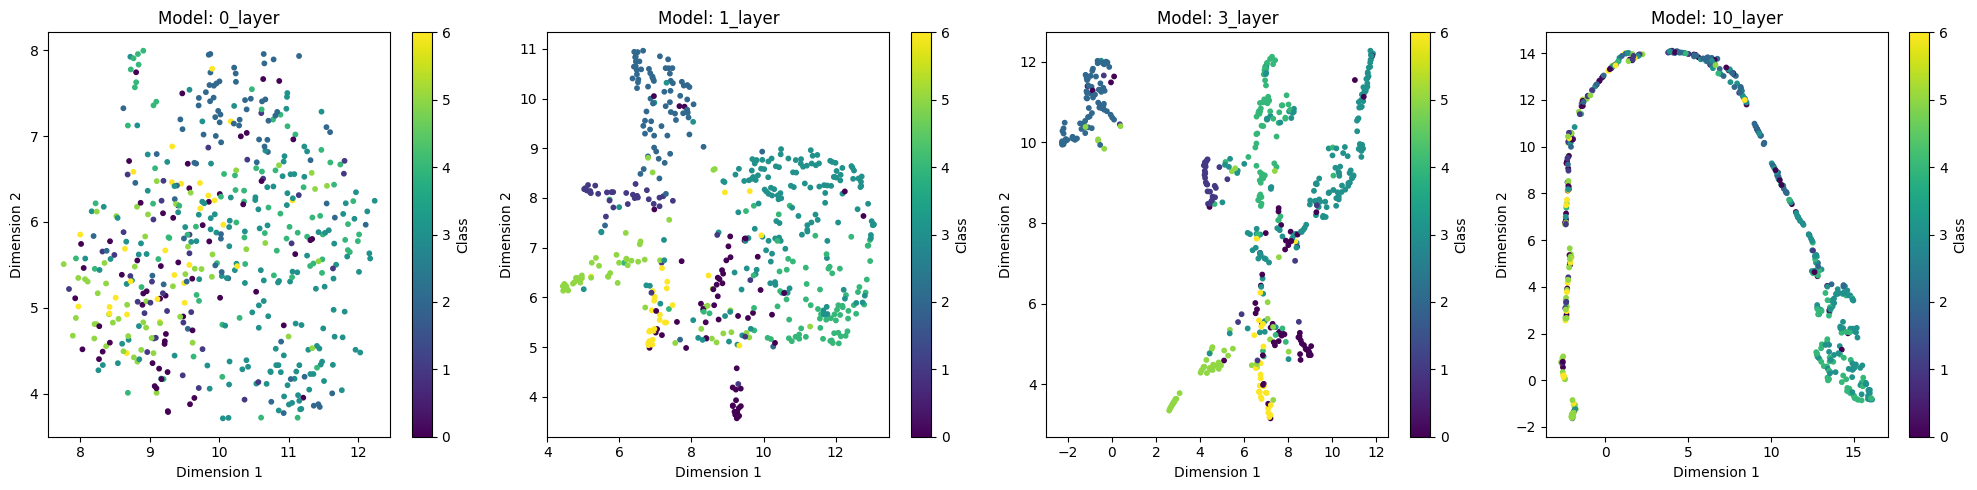

In [226]:
visualise(feature_dict_umap)

## Part 2. Skip-Connections

In this section, we will investigate whether skip-connections can alleviate the effect of over-smoothing.

#### a. Task 5) Setup graph convolutional network with skip-connections
Define a SkipGCN class for node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using **residual connection** is recommended, but you may also use other techniques, like **concatenation**.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [237]:
class SkipGCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hid_dim: int,
        n_classes: int,
        n_layers: int,
        dropout_ratio: float = 0.3):
        super(SkipGCN, self).__init__()

        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
        
        self.layers = nn.ModuleList()
        
        if n_layers == 0:
            self.layers.append(nn.Linear(input_dim, hid_dim))
        
        else:
            # Input layer
            self.layers.append(GCNConv(input_dim, hid_dim))
            
            # Hidden layers with skip connections
            for _ in range(n_layers - 1):
                self.layers.append(GCNConv(hid_dim, hid_dim))
                
            # Output layer
            self.layers.append(nn.Linear(hid_dim, n_classes))
    
    def forward(self, X, A):
        
        if self.n_layers == 0:
            return self.layers[0](X)

        X_res = X  # Initialize residual as input tensor

        for i, layer in enumerate(self.layers[:-1]):

           
            if i == 0:
                X_res = F.relu(layer(X_res, A))
             
            else:
                updateX = F.relu(layer(X_res, A))  # Residual addition
                updateX = F.dropout(X_res, p=self.dropout_ratio, training=self.training)
                X_res = updateX + X_res



        
        logits = self.layers[-1](X_res) # apply last layer
        
        return logits

    def generate_node_embeddings(self, X, A):
       
        X_res = X
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:
                X_res = F.relu(layer(X_res, A))
            else:
                X_res = F.relu(layer(X_res, A) + X_res)
        return X_res

    def param_init(self):
        for layer in self.layers:
            if hasattr(layer, 'weight') and layer.weight is not None:
                nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
            
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias)  # Zero initialization for biases


#### b. Repeat experiments and Visualise the embeddings

In [238]:
torch.manual_seed(123) # set seed

In [239]:
training_params['model_name'] = 'SkipGCN'

training_params["n_layers"] = 0
model_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer = train(training_params)

training_params["n_layers"] = 3
model_3_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer = train(training_params)

/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/100 - Loss: 4.1693, Val Accuracy: 0.0600
Epoch 2/100 - Loss: 3.9826, Val Accuracy: 0.1400
Epoch 3/100 - Loss: 3.7975, Val Accuracy: 0.2440
Epoch 4/100 - Loss: 3.6143, Val Accuracy: 0.3020
Epoch 5/100 - Loss: 3.4333, Val Accuracy: 0.3240
Epoch 6/100 - Loss: 3.2550, Val Accuracy: 0.3340
Epoch 7/100 - Loss: 3.0796, Val Accuracy: 0.3540
Epoch 8/100 - Loss: 2.9077, Val Accuracy: 0.4060
Epoch 9/100 - Loss: 2.7396, Val Accuracy: 0.4260
Epoch 10/100 - Loss: 2.5760, Val Accuracy: 0.4420
Epoch 11/100 - Loss: 2.4172, Val Accuracy: 0.4540
Epoch 12/100 - Loss: 2.2639, Val Accuracy: 0.4560
Epoch 13/100 - Loss: 2.1167, Val Accuracy: 0.4540
Epoch 14/100 - Loss: 1.9759, Val Accuracy: 0.4600
Epoch 15/100 - Loss: 1.8420, Val Accuracy: 0.4660
Epoch 16/100 - Loss: 1.7155, Val Accuracy: 0.4600
Epoch 17/100 - Loss: 1.5965, Val Accuracy: 0.4600
Epoch 18/100 - Loss: 1.4854, Val Accuracy: 0.4600
Epoch 19/100 - Loss: 1.3821, Val Accuracy: 0.4620
Epoch 20/100 - Loss: 1.2866, Val Accuracy: 0.4640
Early sto

In [240]:
feature_dict = {
    "0_layer": dimension_reduction_umap(model_0_layer, dataset.data, device),
    "1_layer": dimension_reduction_umap(model_1_layer, dataset.data, device),
    "3_layer": dimension_reduction_umap(model_3_layer, dataset.data, device),
    "10_layer": dimension_reduction_umap(model_10_layer, dataset.data, device),
}

/Users/fairyliu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the

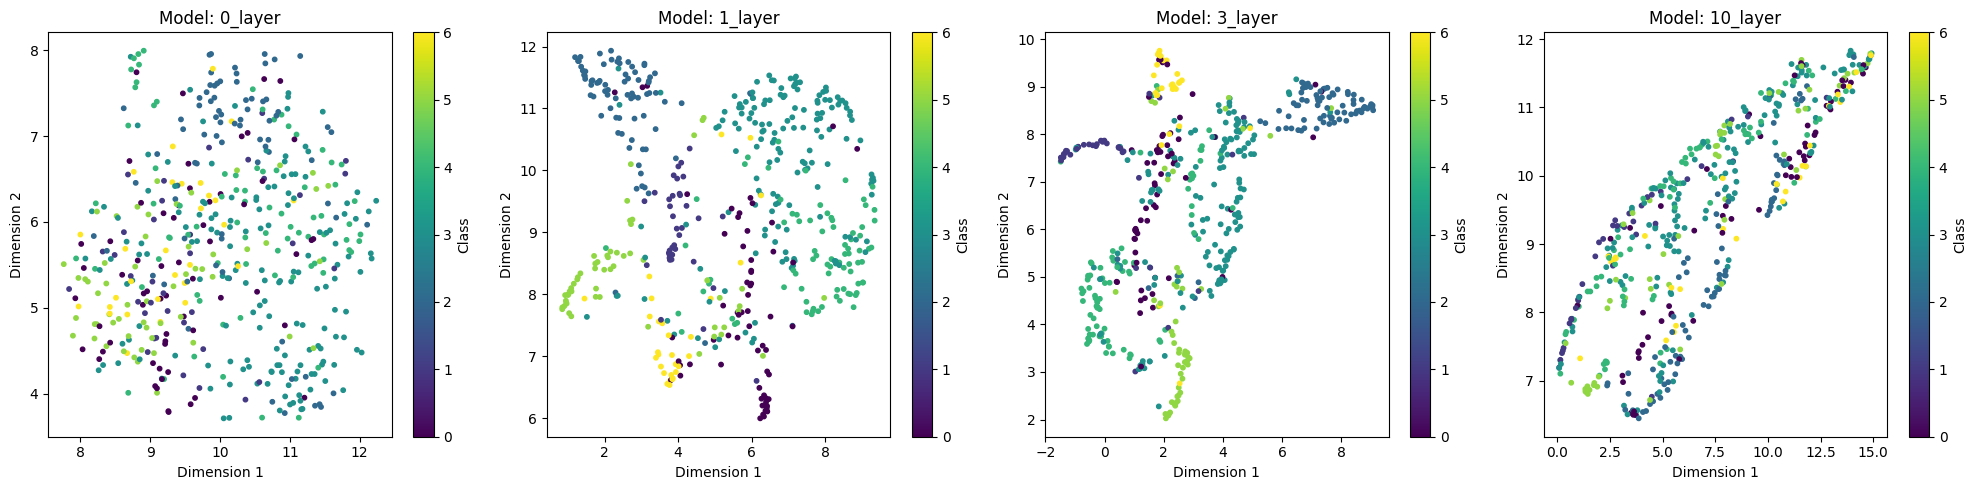

In [241]:
visualise(feature_dict)

## Optional) Jumping Knowledge Connection

#### a. Task6) Design Graph Convolutional Network with Jumping Knowledge Connection
Define a `JumpKnowGCN` class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using `max_pooling` is recommended but you may also use other differentiable functions.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `relu` and `dropout` at the end of each layer.


In [271]:
class JumpKnowGCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hid_dim: int,
        n_classes: int,
        n_layers: int,
        dropout_ratio: float = 0.3):
        super(JumpKnowGCN, self).__init__()
      
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_dim, hid_dim))

        for _ in range(n_layers - 1):
            self.layers.append(GCNConv(hid_dim, hid_dim))
        
        # Output layer
        self.layers.append(nn.Linear(hid_dim, n_classes))

    def forward(self, X, A) -> torch.Tensor:
        layer_outputs = []

        if self.n_layers == 0:
            return self.layers[0](X)  

        X_res = X  
        
        for i, layer in enumerate(self.layers[:-1]):
            Y = X_res
            if i == 0:
                X_res = F.relu(layer(X_res))  
            else:
                X_res = F.relu(layer(X_res, A)) 
            X_res = F.dropout(X_res, p=self.dropout_ratio, training=self.training)
        

            layer_outputs.append(X_res)
    
        if self.n_layers > 0:
            aggregated_rep = torch.stack(layer_outputs, dim=0)
            aggregated_rep = aggregated_rep.max(dim=0)[0]  # Max pooling across layers
            logits = self.layers[-1](aggregated_rep)  
        else:
            logits = self.layers[-1](X_res)
        
        return logits

    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        layer_outputs = []

        if self.n_layers == 0:
            return self.layers[0](X)  

        X_res = X  
        
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:
                X_res = F.relu(layer(X_res)) 
            else:
                X_res = F.relu(layer(X_res, A)) 
            X_res = F.dropout(X_res, p=self.dropout_ratio, training=self.training)
            layer_outputs.append(X_res)
        
        if self.n_layers > 0:
            aggregated_rep = torch.stack(layer_outputs, dim=0)
            aggregated_rep = aggregated_rep.max(dim=0)[0]  # Max pooling across layers
        else:
            aggregated_rep = X_res
        
        return aggregated_rep

    def param_init(self):
        for layer in self.layers:
            if hasattr(layer, 'weight') and layer.weight is not None:
                nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
            
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias)  # Zero initialization for biases


#### b. Repeat experiments and Visualise the embeddings

In [272]:
training_params['model_name'] = 'JumpKnowGCN'
torch.manual_seed(123)

training_params["n_layers"] = 0
model_0_layer = train(training_params)

training_params["n_layers"] = 1
model_1_layer = train(training_params)

training_params["n_layers"] = 3
model_3_layer = train(training_params)

training_params["n_layers"] = 10
model_10_layer = train(training_params)

Epoch 1/100 - Loss: 4.1992, Val Accuracy: 0.0520
Epoch 2/100 - Loss: 4.0122, Val Accuracy: 0.1220
Epoch 3/100 - Loss: 3.8268, Val Accuracy: 0.2080
Epoch 4/100 - Loss: 3.6433, Val Accuracy: 0.2520
Epoch 5/100 - Loss: 3.4620, Val Accuracy: 0.2820
Epoch 6/100 - Loss: 3.2832, Val Accuracy: 0.3200
Epoch 7/100 - Loss: 3.1073, Val Accuracy: 0.3420
Epoch 8/100 - Loss: 2.9348, Val Accuracy: 0.3560
Epoch 9/100 - Loss: 2.7662, Val Accuracy: 0.3880
Epoch 10/100 - Loss: 2.6018, Val Accuracy: 0.3960
Epoch 11/100 - Loss: 2.4423, Val Accuracy: 0.4120
Epoch 12/100 - Loss: 2.2882, Val Accuracy: 0.4240
Epoch 13/100 - Loss: 2.1401, Val Accuracy: 0.4320
Epoch 14/100 - Loss: 1.9983, Val Accuracy: 0.4340
Epoch 15/100 - Loss: 1.8634, Val Accuracy: 0.4380
Epoch 16/100 - Loss: 1.7359, Val Accuracy: 0.4500
Epoch 17/100 - Loss: 1.6158, Val Accuracy: 0.4520
Epoch 18/100 - Loss: 1.5036, Val Accuracy: 0.4520
Epoch 19/100 - Loss: 1.3991, Val Accuracy: 0.4520
Epoch 20/100 - Loss: 1.3025, Val Accuracy: 0.4520
Epoch 21/

In [273]:
feature_dict = {
    "0_layer": dimension_reduction_umap(model_0_layer, dataset.data, device),
    "1_layer": dimension_reduction_umap(model_1_layer, dataset.data, device),
    "3_layer": dimension_reduction_umap(model_3_layer, dataset.data, device),
    "10_layer": dimension_reduction_umap(model_10_layer, dataset.data, device),
}

/Users/fairyliu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/fairyliu/anaconda3/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the

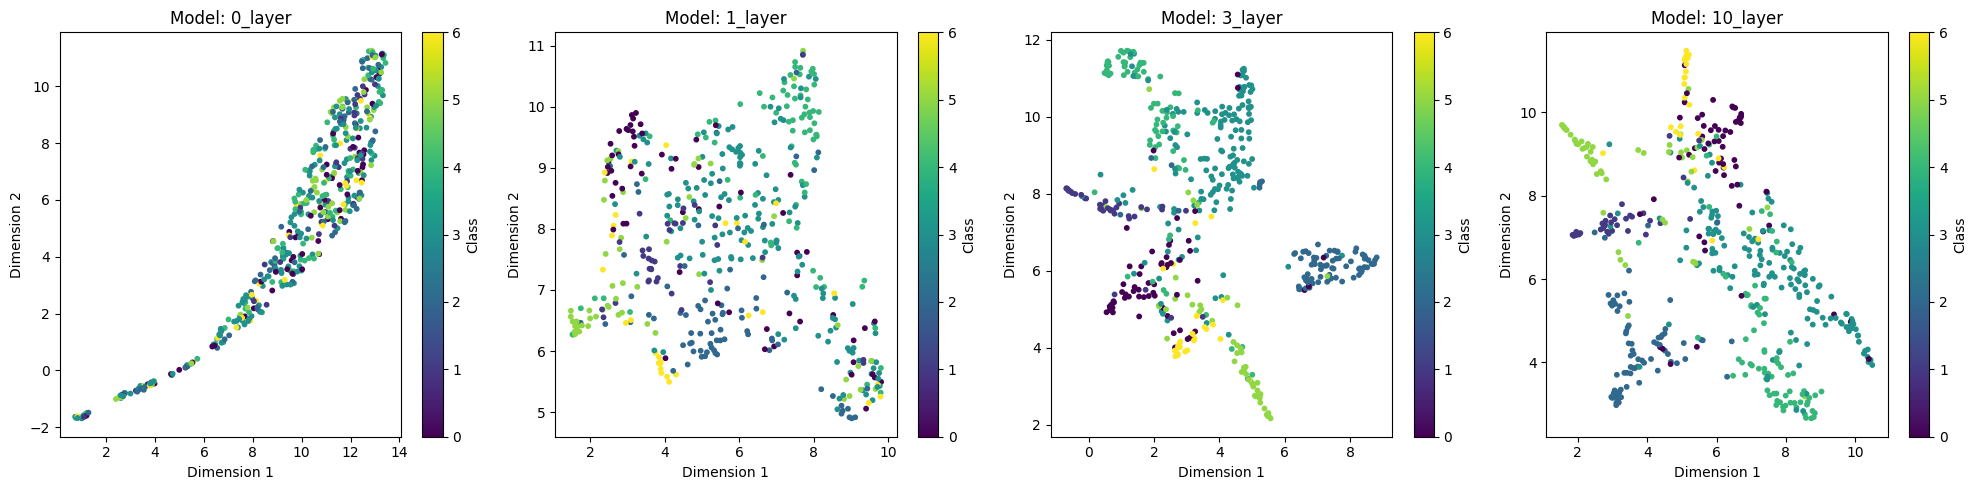

In [274]:
visualise(feature_dict)